In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from dtreeviz.trees import *

In [20]:
# https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling
# Carregar
dados = pd.read_csv('dados/Churn_Modelling.csv', sep=',')
dados.columns.to_list()


['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [21]:
dados.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [22]:
# Drop 
dados = dados.drop(columns=['RowNumber', 'CustomerId', 'Surname'])


In [23]:
#Renomeando colunas para referenciar mais fácil

rename_columns = {
    'CreditScore' : 'cr_score',
    'Geography' : 'country',
    'Gender' : 'gender',
    'Age' : 'age',
    'Tenure' : 'tenure',
    'Balance': 'balance',
    'NumOfProducts': 'n_products',
    'HasCrCard' : 'cr_card',
    'IsActiveMember' : 'active',
    'EstimatedSalary' : 'estimated_salary',
    'Exited' : 'exited'
}

dados = dados.rename(columns=rename_columns)

In [24]:
#Não há dados nulos no dataset

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cr_score          10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   n_products        10000 non-null  int64  
 7   cr_card           10000 non-null  int64  
 8   active            10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


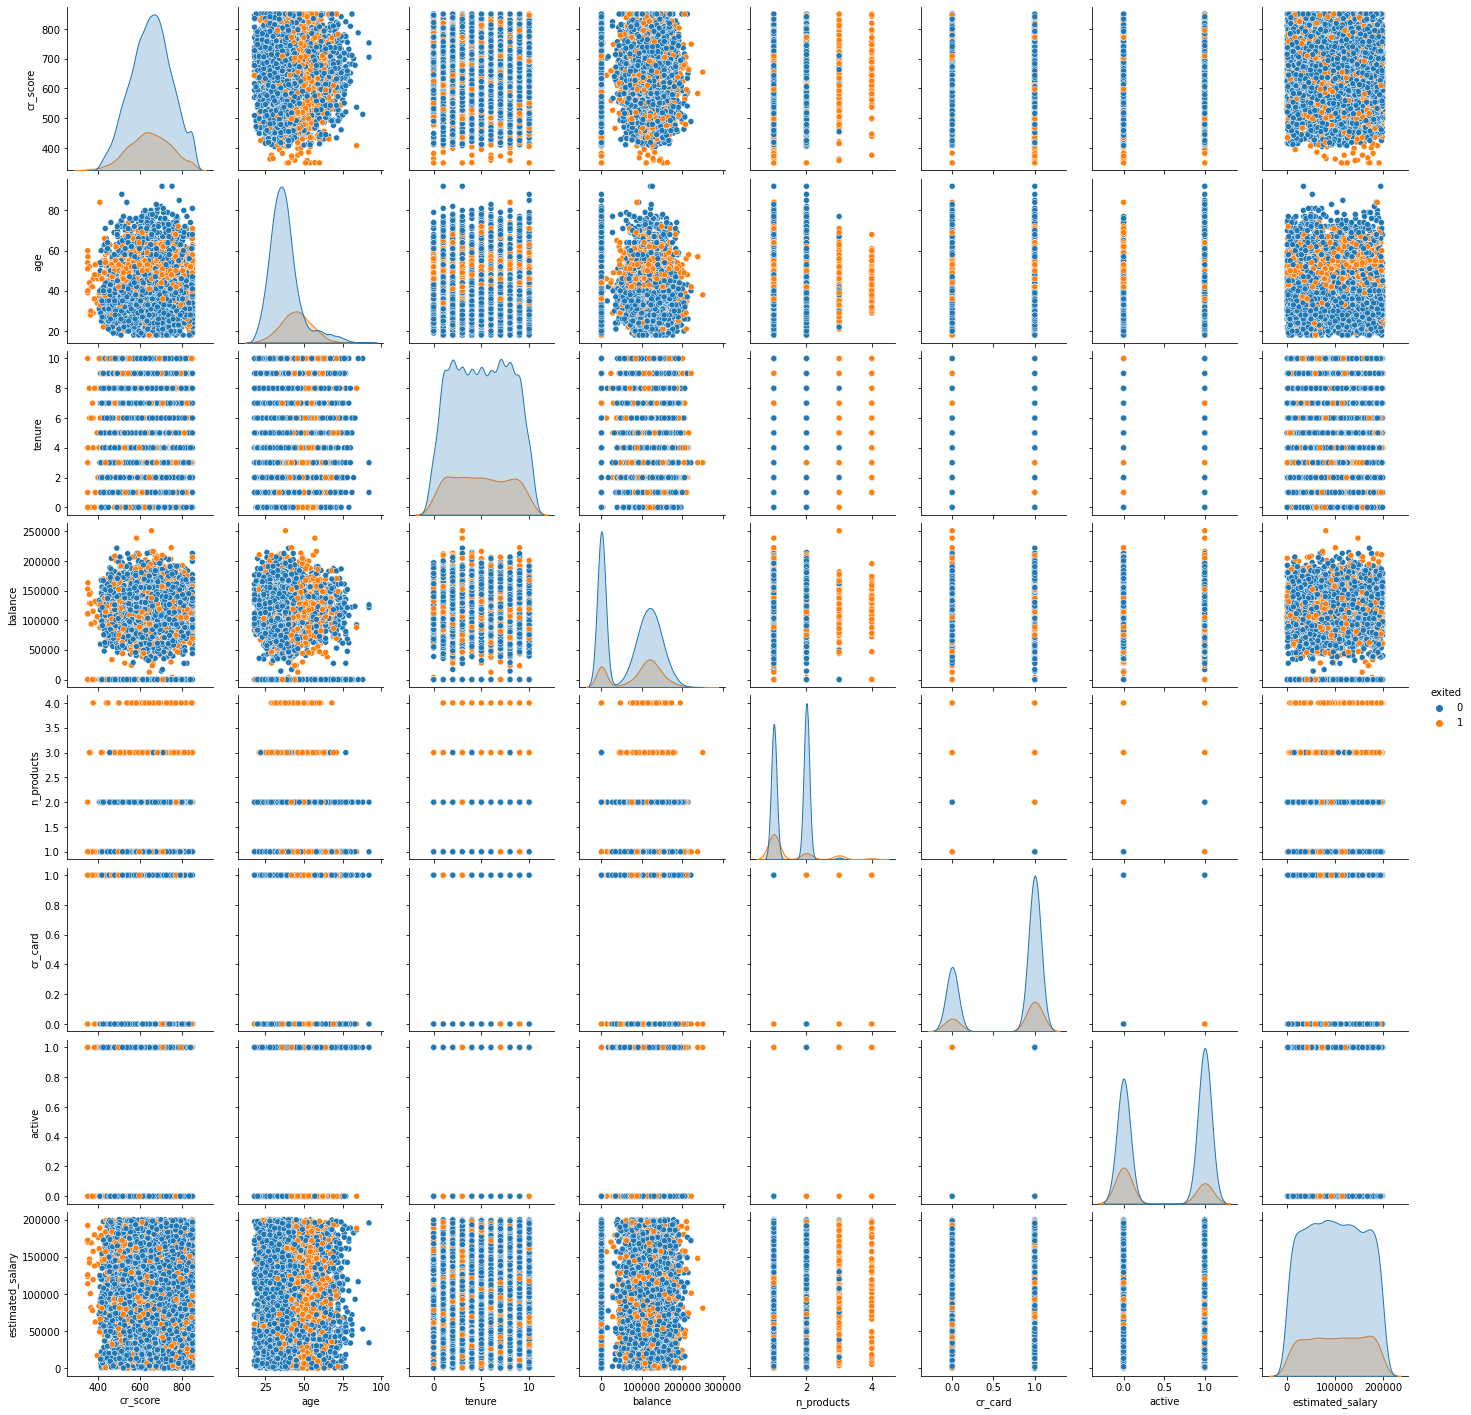

In [25]:
sns.pairplot(dados, hue='exited')
plt.show()

In [26]:
#Estatísticas descritivas desconsiderando algumas colunas discretas/categóricas

df_descritivo = dados.drop(columns=['country', 'gender', 'n_products', 'cr_card', 'active', 'exited'])
df_descritivo.describe()

,cr_score,age,tenure,balance,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,199992.480000


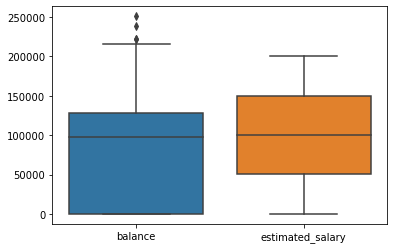

In [27]:
#Boxplot de balanço e salário. Whis ajustado para 75% do IQR para evidenciar outliers
sns.boxplot(data=dados[['balance', 'estimated_salary']], whis=0.7)
plt.show()

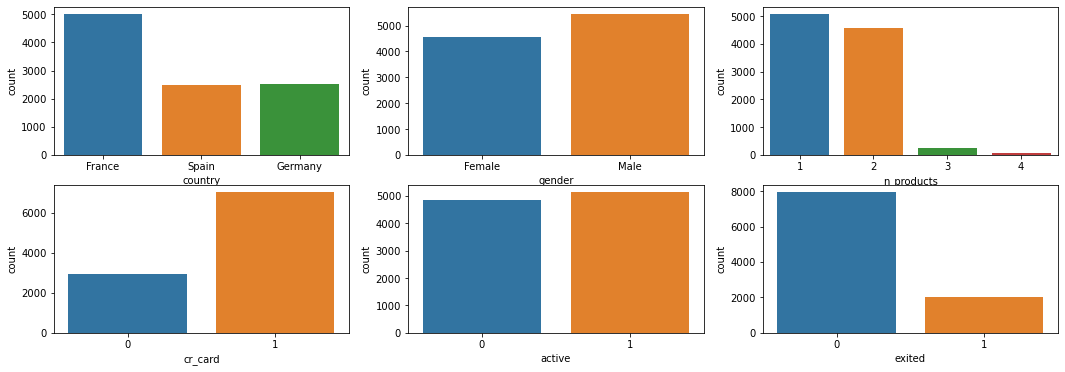

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,6))

plt.subplot(2,3,1)
sns.countplot(x='country', data=dados)

plt.subplot(2,3,2)
sns.countplot(x='gender', data=dados)

plt.subplot(2,3,3)
sns.countplot(x='n_products', data=dados)

plt.subplot(2,3,4)
sns.countplot(x='cr_card', data=dados)

plt.subplot(2,3,5)
sns.countplot(x='active', data=dados)

plt.subplot(2,3,6)
sns.countplot(x='exited', data=dados)

plt.show()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

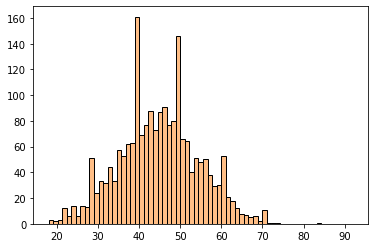

In [29]:
#Histograma com as idades dos clientes
sns.histplot(x='age', data=dados, hue='exited', kde=True)
plt.show()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

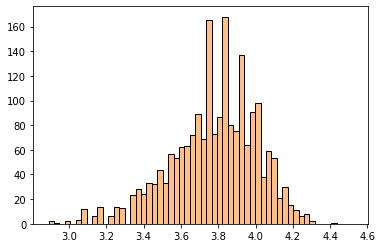

In [30]:
#A distribuição assimétrica de idades pode comprometer a performance do modelo.
#Logo, uma transformação log normal pode melhorar a capacidade de predição

dados['age'] = np.log(dados.age)

sns.histplot(x='age', data=dados, hue='exited', kde=True)
plt.show()

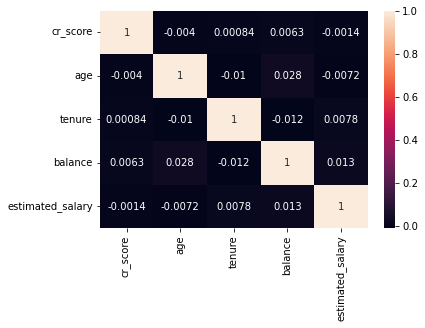

In [31]:
#Features consideradas para estatística descritiva possuem correlação fraca entre si
#Isso corrobora com a hipótese de que não há características redundantes no dataset

corr = df_descritivo.corr()

sns.heatmap(corr, annot=True)
plt.show()

In [32]:
#Categorização do balanço bancário

conditions = [(dados.balance == 0), (dados.balance>0)]
values = [0, 1]
dados['acc_balance'] = np.select(conditions, values)
dados.drop(columns='balance', inplace=True)

In [33]:
#Categorização do número de produtos

conditions = [(dados.n_products==1), (dados.n_products==2), (dados.n_products>2)]
values = ['1 produto', '2 produtos', '> 2 produtos']
dados['products'] = np.select(conditions, values)
dados.drop(columns='n_products', inplace=True)

In [34]:
#Codificação de features categóricas em preparação para os modelos

df_dummies = pd.get_dummies(dados[['country', 'gender', 'products']], drop_first=True)
rename_dummies = {
    'country_Germany' : 'germany',
    'country_Spain': 'spain',
    'gender_Male': 'male',
    'products_2 produtos': '2_products',
    'products_> 2 produtos': '>2_products'
}

df_dummies = df_dummies.rename(columns=rename_dummies)

novos_dados = pd.concat([dados, df_dummies], axis=1).drop(columns=['country', 'gender', 'products'])
novos_dados = novos_dados[['cr_score','germany', 'spain', 'male', 'age', 'tenure', 'acc_balance', '2_products', '>2_products', 'cr_card', 'active', 'estimated_salary', 'exited']]
novos_dados.head()

,cr_score,germany,spain,male,age,tenure,acc_balance,2_products,>2_products,cr_card,active,estimated_salary,exited
0,619,False,False,False,3.737670,2,0,False,False,1,1,101348.88,1
1,608,False,True,False,3.713572,1,1,False,False,0,1,112542.58,0
2,502,False,False,False,3.737670,8,1,False,True,1,0,113931.57,1
3,699,False,False,False,3.663562,1,0,True,False,0,0,93826.63,0
4,850,False,True,False,3.761200,2,1,False,False,1,1,79084.10,0


## Features

In [35]:
X = novos_dados.drop(columns=['exited'])
y = novos_dados.exited
cols = X.columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=69)

scale_cols = ['cr_score', 'estimated_salary']
cat_cols = [col for col in cols if col not in scale_cols]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[scale_cols])
X_test_scaled = scaler.transform(X_test[scale_cols])

X_train_df = pd.DataFrame(X_train_scaled, columns=scale_cols)
X_train_df = pd.concat([X_train_df, X_train[cat_cols].reset_index(drop=True)], axis=1)

X_test_df = pd.DataFrame(X_test_scaled, columns=scale_cols)
X_test_df = pd.concat([X_test_df, X_test[cat_cols].reset_index(drop=True)], axis=1)

ov = SMOTE(random_state=42)

X_train_ov, y_train_ov = ov.fit_resample(X_train_df, y_train)


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=42)
X_train_un, y_train_un = undersample.fit_resample(X_train_df, y_train)

# Modelos

### Random Forest

In [18]:
colunas_keep = [
    'cr_score',
    'estimated_salary',
    'germany',
    'male',
    'age',
    'acc_balance',
    '2_products',
    'active',
]
X_train_keep = X_train_ov[colunas_keep]
X_test_keep = X_test_df[colunas_keep]

# X_train_test = X_train_ov.copy()
# X_test_test = X_test_df.copy()

# Depois de alguns experimentos
rf = RandomForestClassifier(
    n_estimators=100,
    max_features=0.4,
    random_state=42,
    n_jobs=4,
    min_samples_leaf=50,
    max_depth=200,
    min_samples_split=10

)
rf.fit(X_train_keep, y_train_ov)
predict = rf.predict(X_test_keep)
recall = recall_score(y_test, predict)
print(f'recall: {recall}')

recall: 0.7103109656301145


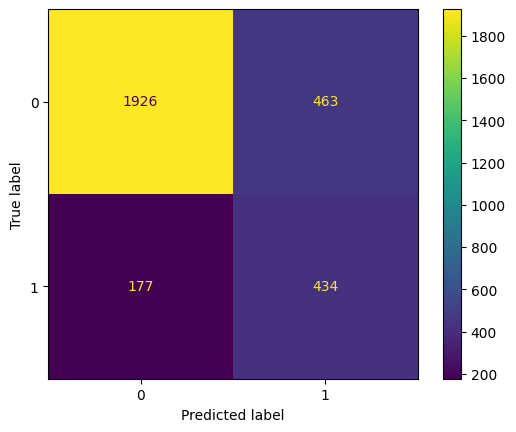

In [26]:
cm  = confusion_matrix(y_test, predict)
displ = ConfusionMatrixDisplay(confusion_matrix=cm)

displ.plot()

### Importancia das features

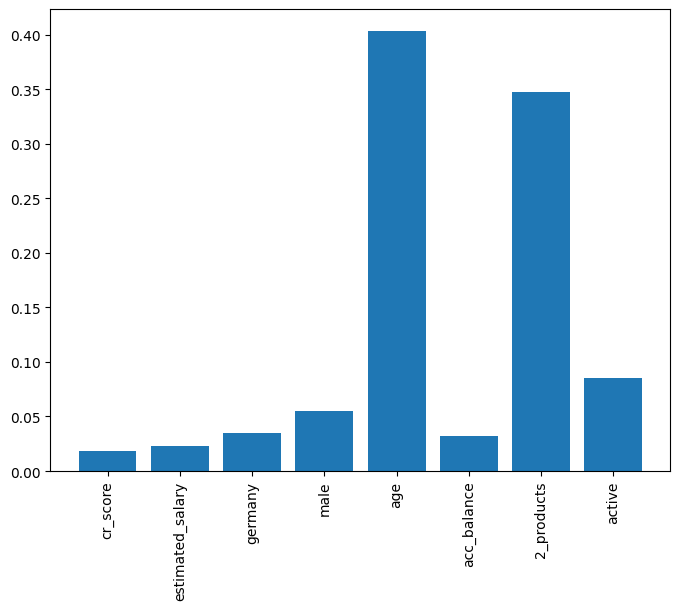

In [27]:
fig_impor, ax_impor  = plt.subplots(figsize=(8,6))
colunas = X_test_keep.columns.to_list()
import_feat = rf.feature_importances_
ax_impor.bar(colunas, import_feat)
ax_impor.tick_params(axis='x', labelrotation=90)


### Grid search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    'n_estimators': [500, 800, 1000, 1500, 2000, 2500, 3000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6, 8, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}
rf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(rf, param_grid=params, scoring='recall', cv=5, verbose=3)
grid_search  = RandomizedSearchCV(rf, params, n_iter=100, scoring='recall', cv=5, random_state=42)
grid_search.fit(X_train_ov, y_train_ov)

best_params = grid_search.best_params_
print('Best parameters: ', best_params)

best_recall = grid_search.score(X_test_df, y_test)
print('Best recall: ', best_recall)

### MLPClassifier

In [9]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(X_train_ov, y_train_ov)
mlp_pred = mlp.predict(X_test_df)
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.91      0.79      0.84      2389
           1       0.46      0.70      0.55       611

    accuracy                           0.77      3000
   macro avg       0.68      0.74      0.70      3000
weighted avg       0.82      0.77      0.79      3000



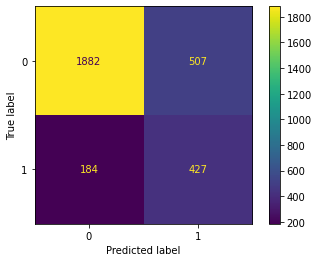

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, mlp_pred)).plot()
plt.show()

Otimizando Hiperparâmetros com RandomizedSearchCV

In [12]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'hidden_layer_sizes' : [100, 200, 300],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [100, 200, 300, 500]
}

random_search = RandomizedSearchCV(MLPClassifier(), params, n_iter=100, scoring='recall', cv=5, n_jobs = 3, random_state=42)
random_search.fit(X_train_ov, y_train_ov)

best_params = random_search.best_params_
print('Best parameters: ', best_params)

best_recall = random_search.score(X_test_df, y_test)
print('Best recall: ', best_recall)

Best parameters:  {'max_iter': 300, 'learning_rate': 'constant', 'hidden_layer_sizes': 100, 'activation': 'relu'}
Best recall:  0.6415711947626841


Otimizando Hiperparâmetros com GridSearchCV

In [13]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    'hidden_layer_sizes' : [100, 200, 300, 400, 500],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [100, 200, 300, 400, 500, 600],
    'warm_start' : [True, False]
}

grid_search  = GridSearchCV(MLPClassifier(), params, n_jobs = 3, scoring=['precision', 'recall'], refit = refit_strategy)
grid_search.fit(X_train_ov, y_train_ov)


All grid-search results:
precision: 0.797 (±0.004), recall: 0.824 (±0.128), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 100, 'warm_start': True}
precision: 0.791 (±0.021), recall: 0.843 (±0.080), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 100, 'warm_start': False}
precision: 0.810 (±0.025), recall: 0.809 (±0.091), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'warm_start': True}
precision: 0.803 (±0.026), recall: 0.830 (±0.072), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'warm_start': False}
precision: 0.794 (±0.024), recall: 0.842 (±0.081), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 300, 'warm_start': True}
precision: 0.793 (±0.020), recall: 0.838 (±0.088), for {'activation': 'identity', 'hidden_layer_si

GridSearchCV(estimator=MLPClassifier(), n_jobs=3,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [100, 200, 300, 400, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 200, 300, 400, 500, 600],
                         'warm_start': [True, False]},
             refit=<function refit_strategy at 0x000002ABC22BFBE0>,
             scoring=['precision', 'recall'])

In [15]:
grid_best_parameters = grid_search.best_params_
print(grid_best_parameters)

{'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'max_iter': 600, 'warm_start': False}


In [17]:
opt_pred = grid_search.predict(X_test_df)
print(recall_score(y_test, opt_pred))

0.6513911620294599


In [20]:
mlp_opt = MLPClassifier(activation = 'identity', hidden_layer_sizes = 100, learning_rate = 'adaptive', max_iter = 600, warm_start = False)

mlp_opt.fit(X_train_ov, y_train_ov)
mlp_opt_pred = mlp_opt.predict(X_test_df)

print(classification_report(y_test, mlp_opt_pred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      2389
           1       0.44      0.70      0.54       611

    accuracy                           0.76      3000
   macro avg       0.67      0.74      0.69      3000
weighted avg       0.81      0.76      0.78      3000



### Decision Tree

In [ ]:
#usando dados após Smote
ad = DecisionTreeClassifier(random_state=42)
ad.fit(X_train_ov, y_train_ov)
predict = ad.predict(X_test_df)
recall = recall_score(y_test, predict)
print(recall)

print(confusion_matrix(y_test,predict))

print(classification_report(y_test,predict))


0.486088379705401
[[1945  444]
 [ 314  297]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      2389
           1       0.40      0.49      0.44       611

    accuracy                           0.75      3000
   macro avg       0.63      0.65      0.64      3000
weighted avg       0.77      0.75      0.76      3000



In [ ]:
#usando dados após Undersampling
ad = DecisionTreeClassifier(random_state=42)
ad.fit(X_train_un, y_train_un)
predict = ad.predict(X_test_df)
recall = recall_score(y_test, predict)
print(recall)

print(confusion_matrix(y_test,predict))

print(classification_report(y_test,predict))

0.7201309328968903
[[1625  764]
 [ 171  440]]
              precision    recall  f1-score   support

           0       0.90      0.68      0.78      2389
           1       0.37      0.72      0.48       611

    accuracy                           0.69      3000
   macro avg       0.64      0.70      0.63      3000
weighted avg       0.79      0.69      0.72      3000



Otimizando parâmetros com RandomizedSearch

In [ ]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6, 8, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,10],
    'splitter':['best','random']
}
ad = DecisionTreeClassifier(random_state=42)
# grid_search = GridSearchCV(rf, param_grid=params, scoring='recall', cv=5, verbose=3)
grid_search  = RandomizedSearchCV(ad, params, n_iter=10000, scoring='recall', cv=5, random_state=42)
grid_search.fit(X_train_un, y_train_un)

best_params = grid_search.best_params_
print('Best parameters: ', best_params)

best_recall = grid_search.score(X_test_df, y_test)
print('Best recall: ', best_recall)

Best parameters:  {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': 10, 'max_depth': 50, 'criterion': 'gini'}
Best recall:  0.7774140752864157


Treinando modelo com parâmetros otimizados

              precision    recall  f1-score   support

           0       0.93      0.74      0.83      2389
           1       0.44      0.78      0.56       611

    accuracy                           0.75      3000
   macro avg       0.68      0.76      0.69      3000
weighted avg       0.83      0.75      0.77      3000



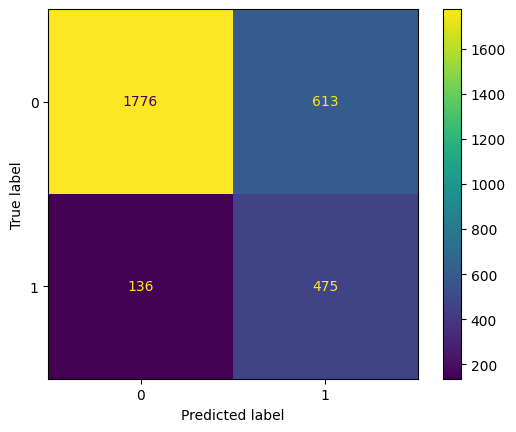

In [ ]:
ad = DecisionTreeClassifier(random_state=42,splitter= 'random', min_samples_split= 10, min_samples_leaf= 13, max_features= 10, max_depth= 50, criterion= 'gini')
ad.fit(X_train_un, y_train_un)
predict = ad.predict(X_test_df)
recall = recall_score(y_test, predict)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predict)).plot()

print(classification_report(y_test,predict))

Importânia das features

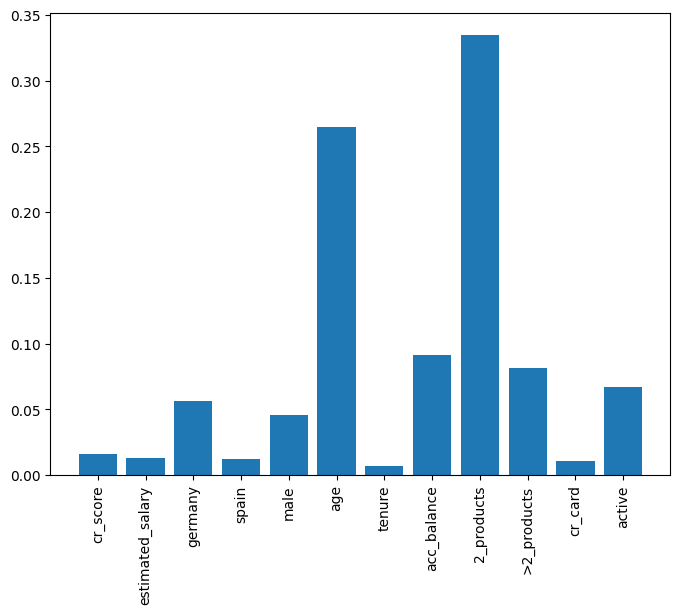

In [ ]:
fig_impor, ax_impor  = plt.subplots(figsize=(8,6))
colunas = X_test_df.columns.to_list()
import_feat = ad.feature_importances_
ax_impor.bar(colunas, import_feat)
ax_impor.tick_params(axis='x', labelrotation=90)

Visualização das árvores de decisão

[Text(0.5, 0.9, '2_products <= 0.16\ngini = 0.5\nsamples = 2852\nvalue = [1426, 1426]\nclass = e'),
 Text(0.25, 0.7, 'age <= 3.848\ngini = 0.46\nsamples = 1844\nvalue = [662, 1182]\nclass = x'),
 Text(0.125, 0.5, '>2_products <= 0.042\ngini = 0.496\nsamples = 1257\nvalue = [572, 685]\nclass = x'),
 Text(0.0625, 0.3, 'germany <= 0.033\ngini = 0.5\nsamples = 1140\nvalue = [566, 574]\nclass = x'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'cr_score <= 0.8\ngini = 0.097\nsamples = 117\nvalue = [6, 111]\nclass = x'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'germany <= 0.691\ngini = 0.26\nsamples = 587\nvalue = [90, 497]\nclass = x'),
 Text(0.3125, 0.3, 'active <= 0.708\ngini = 0.322\nsamples = 367\nvalue = [74, 293]\nclass = x'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'active <= 0.092\ngini = 0.135\nsamples = 220\nvalue = [16, 204

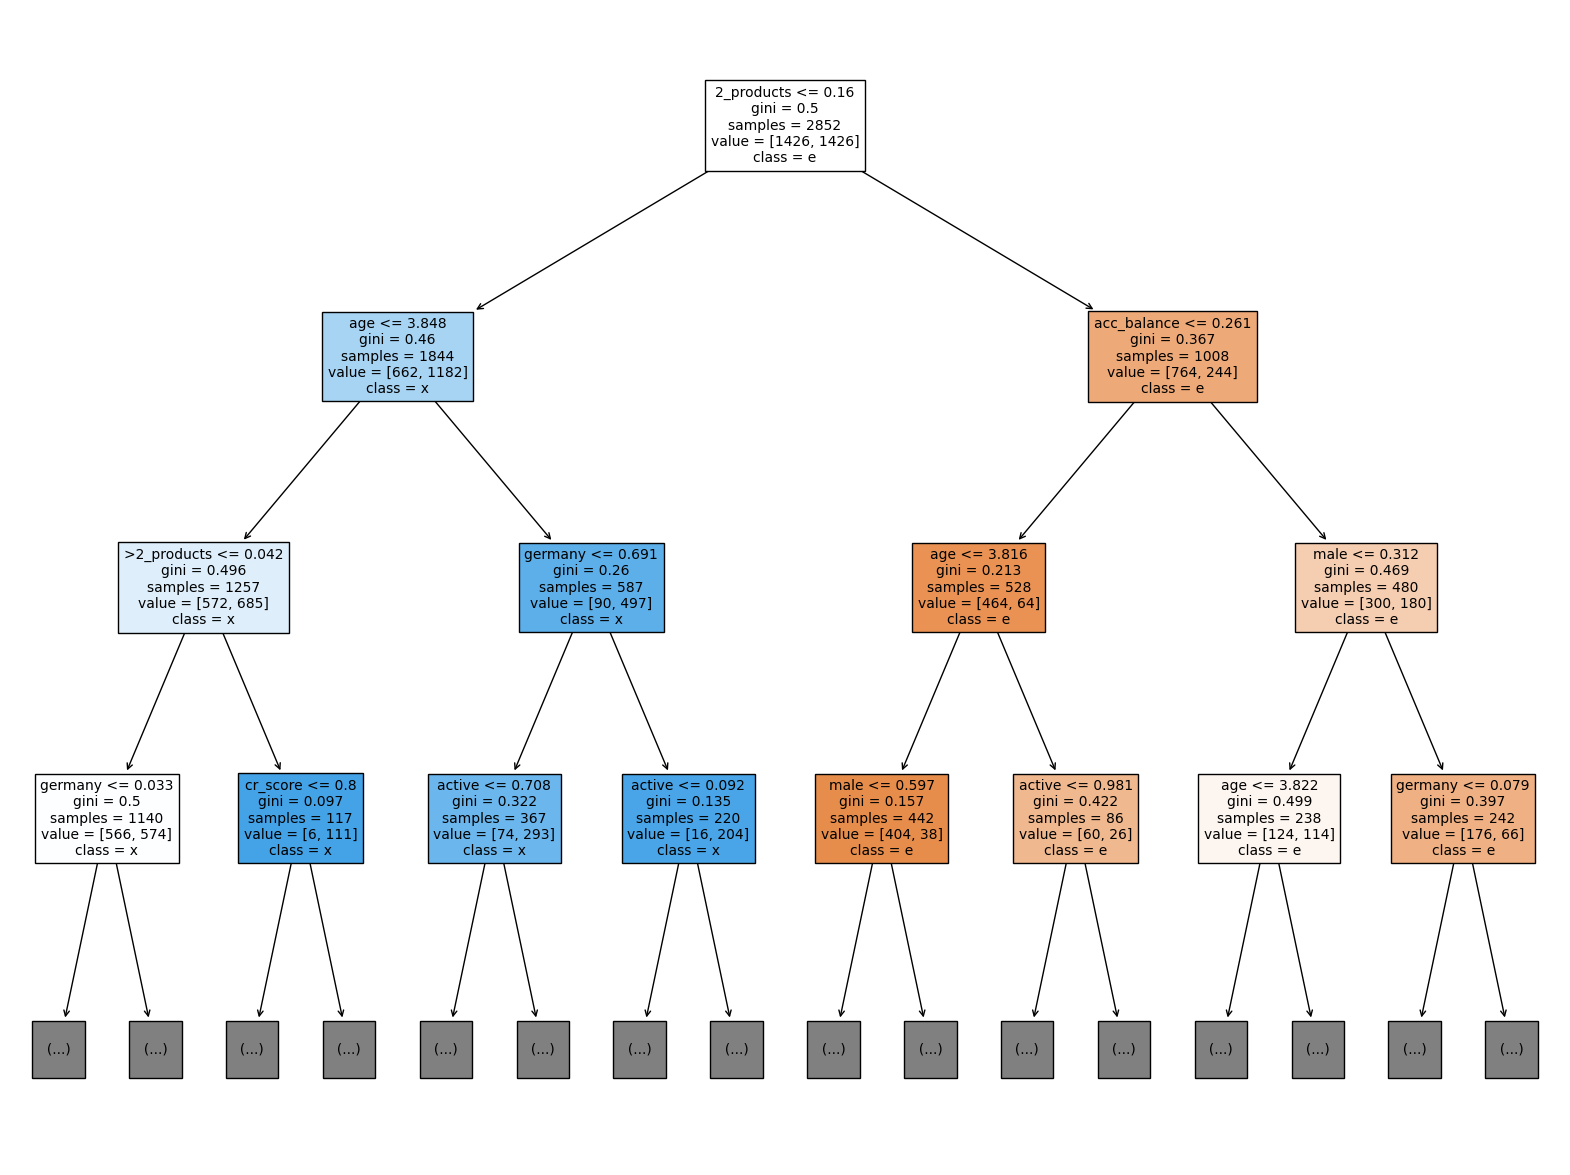

In [ ]:
fig = plt.figure(figsize=(20,15))
plot_tree(ad, 
                   feature_names=list(X_train_un.columns),
                    class_names=list(y_train_un.name),
                   filled=True,max_depth=3,fontsize=10)

### Logistic Regression

In [76]:
log_reg = LogisticRegression()
log_reg.fit(X_train_ov, y_train_ov)
log_reg_predict = log_reg.predict(X_test_df)
log_reg_recall = recall_score(y_test, log_reg_predict)
print(f'recall: {log_reg_recall}')

recall: 0.7545008183306056


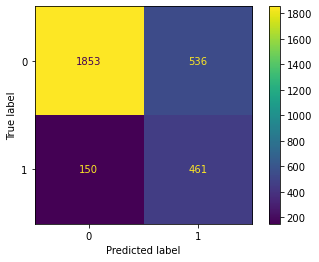

In [72]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, log_reg_predict)).plot()
plt.show()

**Melhores parâmetros para a Regressão Logística**

In [82]:
np.random.seed(42)

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid=params, scoring='recall', cv=5)
grid_search.fit(X_train_ov, y_train_ov)

best_params = grid_search.best_params_
best_recall = grid_search.best_score_

print('Best parameters: ', best_params)
print('Best recall: ', best_recall)

/home/emanuelle/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/home/emanuelle/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/home/emanuelle/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/home/emanuelle/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/home/emanuelle/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best recall:  0.7717997600856606


**Regressão Logística com os melhores parâmetros**

In [83]:
log_reg_best = LogisticRegression(**best_params)
log_reg_best.fit(X_train_ov, y_train_ov)
log_reg_predict = log_reg_best.predict(X_test_df)
log_reg_recall = recall_score(y_test, log_reg_predict)

print(f'recall: {log_reg_recall}')

recall: 0.7561374795417348


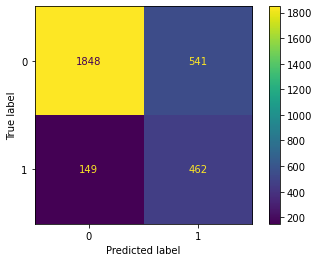

In [84]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, log_reg_predict)).plot()
plt.show()